# Combining two Gaussians

This simple example shows how to use the `ImportanceSampler` tool to represent likelihoods from two partially overlapping Gaussian distributions. In doing so, we can sample from the joint likelihood and obtain a tighter distribution on the parameters. This exercise is also helpful because we know what the answer should be. Given two Gaussian distributions, one with mean and covariance $(\mu_1,\Sigma_1)$ and the other with $(\mu_2,\Sigma_2)$, the mean of the product of the two distributions is
$$
\mu = \Sigma(\Sigma_1^{-1}\mu_1 + \Sigma_2^{-1}\mu_2)
$$
where the covariance is
$$
\Sigma^{-1} = \Sigma_1^{-1} + \Sigma_2^{-1}\,.
$$
If the tool is working correctly, we should recover both the mean and covariance of the joint distribution.

In [1]:
#Import things
import numpy as np
import matplotlib.pyplot as plt
import importance_sampler as isamp
import scipy.stats
import corner, emcee
%matplotlib inline

In [2]:
#Plot formatting
plt.rc("font", size=18, family="serif")
plt.rc("text", usetex=True)

In [3]:
#Gaussian 1
means = np.array([3.0, -0.0])
stddevs = np.array([1.0, 0.1]) #standard deviations
rho = -0.99 #correlation
cov = np.array([[stddevs[0]**2, rho*stddevs[0]*stddevs[1]],
                [rho*stddevs[0]*stddevs[1], stddevs[1]]])
#cov = np.array([[1,0.1],[0.1,0.5]])
icov = np.linalg.inv(cov)

In [4]:
#Draw samples and compute the log liklihoods
N_samples = 100000
chain = np.random.multivariate_normal(mean=means, cov=cov, size=N_samples)
lnlikes = np.log(scipy.stats.multivariate_normal.pdf(chain, mean=means, cov=cov))

In [5]:
#Create the ImportanceSampler object for this chain
IS = isamp.ImportanceSampler(chain, lnlikes, scale=8)
IS.select_training_points(200, method="LH")
IS.train()

      fun: 1244.6752868108852
 hess_inv: array([[0.0001154]])
      jac: array([0.83917236])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 106
      nit: 8
     njev: 92
   status: 2
  success: False
        x: array([2.47166235])


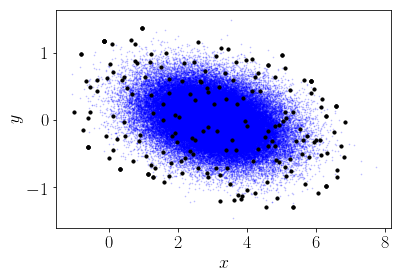

In [6]:
#Plot the chain and show the selected training points in black
plt.scatter(chain[:,0], chain[:,1], c='b', s=0.5, alpha=0.2)
points,_ = IS.get_training_data()
plt.scatter(points[:,0], points[:,1], c='k', s=10)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")

(array([ 3., 15., 28., 57., 51., 29., 11.,  2.,  3.,  1.]),
 array([47.0069371 , 47.00696069, 47.00698427, 47.00700785, 47.00703144,
        47.00705502, 47.0070786 , 47.00710219, 47.00712577, 47.00714935,
        47.00717294]),
 <a list of 10 Patch objects>)

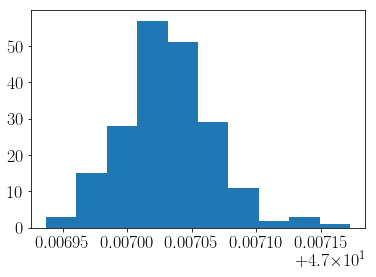

In [15]:
#Error on the prediction
x_train, lnL_train = IS.get_training_data()
lnL_predict = IS.predict(x_train)
lnL_diff = lnL_predict - lnL_train
Pdiff = np.exp(lnL_diff)
Pdiff = (np.exp(lnL_train)-np.exp(lnL_predict))/np.exp(lnL_train)*100
plt.hist(Pdiff)#(Pdiff*10 - 5.3)*1e4);

## Testing the importance sampler object

The only way to truly test if the new sampler works is to use it in an MCMC chain and see if we recover the same posteriors as the original.

In [7]:
#Run a test where we draw from the predicted likelihood surface
def log_likelihood(params):
    return IS.predict(np.atleast_2d(params))

initial = means
ndim, nwalkers = len(initial), 16
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood)
print("Running first burn-in")
p0 = initial + 1e-4*np.random.randn(nwalkers, ndim)
p0, lp, _ = sampler.run_mcmc(p0, 2000)
print("Running second burn-in")
p0 = p0[np.argmax(lp)] + 1e-4*np.random.randn(nwalkers, ndim)
p0, lp, _ = sampler.run_mcmc(p0, 2000)
sampler.reset()
print("Running production...")
sampler.run_mcmc(p0, 2000);

Running first burn-in
Running second burn-in
Running production...


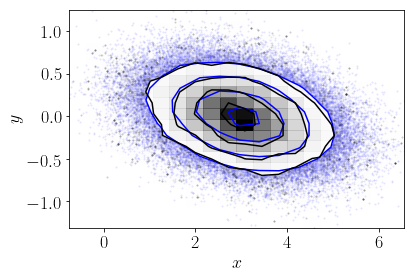

In [8]:
#Plot a KDE histogram of the true chain and the resampled chain
testchain = sampler.flatchain
corner.hist2d(chain[:,0], chain[:,1], color='b', plot_datapoints=1)
corner.hist2d(testchain[:,0], testchain[:,1], color='black', plot_datapoints=1)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.savefig("example_mcmc.png", dpi=300, bbox_inches="tight")

In [9]:
#Gaussian 2
means2 = np.array([4.5, 0.0])
stddevs2 = np.array([0.2, 0.1]) #standard deviations
rho2 = 0.9 #correlation
cov2 = np.array([[stddevs2[0]**2, rho2*stddevs2[0]*stddevs2[1]],
                [rho2*stddevs2[0]*stddevs2[1], stddevs2[1]]])
#cov2 = np.array([[1,0.1],[0.1,0.5]])
icov2 = np.linalg.inv(cov2)

In [10]:
#Samples from the second Gaussian
chain2 = np.random.multivariate_normal(mean=means2, cov=cov2, size=N_samples)
lnlikes2 = np.log(scipy.stats.multivariate_normal.pdf(chain2, mean=means2, cov=cov2))

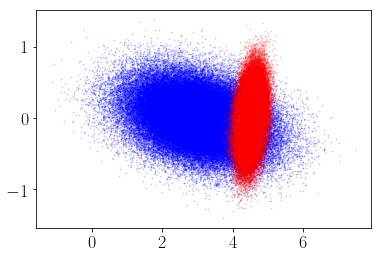

In [11]:
#Plot the two Gaussian distributions
plt.scatter(chain[:,0], chain[:,1], c='b', s=0.5, alpha=0.2)
plt.scatter(chain2[:,0], chain2[:,1], c='r', s=0.5, alpha=0.2)

In [12]:
#Create an ImportanceSampler for the second Gaussian
IS2 = isamp.ImportanceSampler(chain2, lnlikes2, scale=8)
IS2.select_training_points(200, method="LH")
IS2.train()

      fun: 418.79885748124366
 hess_inv: array([[2.09088045e-10]])
      jac: array([0.00158691])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 51
      nit: 9
     njev: 40
   status: 2
  success: False
        x: array([2.31353782])


In [13]:
#Sample from the combined lnlikelihood
def log_likelihood_combined(params):
    return IS.predict(np.atleast_2d(params)) + IS2.predict(np.atleast_2d(params))

initial = means
ndim, nwalkers = len(initial), 16
sampler2 = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood_combined)
print("Running first burn-in")
p0 = initial + 1e-4*np.random.randn(nwalkers, ndim)
p0, lp, _ = sampler2.run_mcmc(p0, 1000)
print("Running second burn-in")
p0 = p0[np.argmax(lp)] + 1e-4*np.random.randn(nwalkers, ndim)
p0, lp, _ = sampler2.run_mcmc(p0, 1000)
sampler2.reset()
print("Running production...")
sampler2.run_mcmc(p0, 2000);

Running first burn-in
Running second burn-in
Running production...


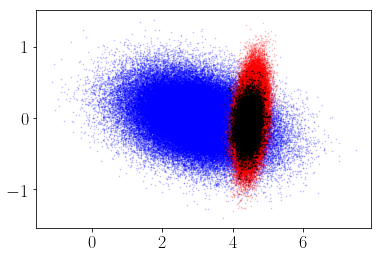

In [14]:
#Make scatter plots of the new chain and the old chains
testchain = sampler2.flatchain
plt.scatter(chain[:,0], chain[:,1], c='b', s=0.5, alpha=0.2)
plt.scatter(chain2[:,0], chain2[:,1], c='r', s=0.5, alpha=0.2)
plt.scatter(testchain[:,0], testchain[:,1], c='k', s=0.5, alpha=0.2)

True covariance:   
[[0.03615963 0.0062533 ]
 [0.0062533  0.0466022 ]]
Sample covariance: 
[[0.0348983  0.0057079 ]
 [0.0057079  0.04750227]]


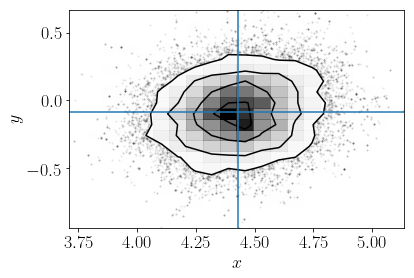

In [15]:
testchain = sampler2.flatchain
true_cov = np.linalg.inv(icov + icov2)
true_means = np.dot(true_cov, np.dot(icov, means) + np.dot(icov2, means2))

print("True covariance:   ")
print(true_cov)
print("Sample covariance: ")
print(np.cov(testchain.T))

corner.hist2d(testchain[:,0], testchain[:,1], color='black', plot_datapoints=1)
plt.axvline(true_means[0])
plt.axhline(true_means[1])
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
#plt.savefig("example_mcmc.png", dpi=300, bbox_inches="tight")

## Great success!!

We see that the tool works as advertised for this example. The recovered sample mean and sample covariane of the re-sampled distribution matches the true mean and covariance given the input distributions.